<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.
project  sample_data  Turbo_rate_1_3.png
MainModel.ipynb  README.md  util.py


In [137]:
import pyldpc
import commpy
import numpy

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [133]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100


In [134]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [138]:
num_parity_check = 3
num_bits_in_parity_check = 6 
ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = np.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 1 1]
 [1 1 1 ... 1 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 0 1 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [139]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = np.array(())
times_per_iter_tensor = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=np.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=np.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 2.02s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.78s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.75s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.47s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 19.01s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.83s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 3.49s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 5.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 6.52s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 16.92s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.31s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.60s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.06s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 12.80s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.07s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [142]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = np.array(())
times_per_iter_awgn = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=np.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=np.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.70s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.37s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.93s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.75s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 16.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.37s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.82s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.32s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.71s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 14.22s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.12s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.32s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.54s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.76s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 11.74s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.85s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.74s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [141]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = np.array(())
times_per_iter_pyldpc = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=np.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=np.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.75s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.41s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.24s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.90s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 17.30s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.67s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.50s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 13.57s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.21s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.41s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.65s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.70s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 11.97s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.91s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.90s
SNR: 1.500 - Iter: 750 - Last 250.0 it

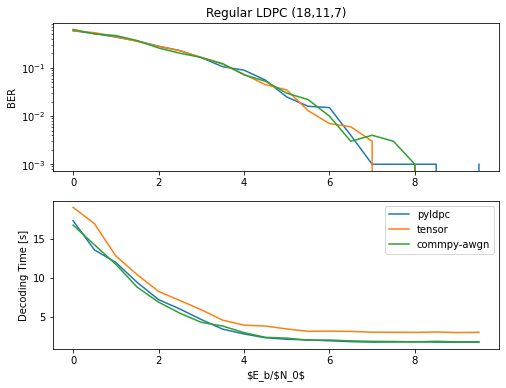

In [183]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: {:03.2f}s'.format(np.sum(times)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 